In [1]:
import pickle
with open('ROMS_26yr_daydic.pkl', 'rb') as file:
    daydic = pickle.load(file)

with open('ROMS_26yr_eddies.pkl', 'rb') as file:
    eddies = pickle.load(file)

In [2]:
import netCDF4 as nc
import numpy as np
import pandas as pd
import math
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

fname = '/srv/scratch/z3533156/26year_BRAN2020/outer_avg_01461.nc'
dataset = nc.Dataset(fname)
lon_rho  = dataset.variables['lon_rho']
lon_rho = np.transpose(lon_rho, axes=(1, 0))
lat_rho  = dataset.variables['lat_rho']
lat_rho = np.transpose(lat_rho, axes=(1, 0))
z_r = np.load('/home/z5297792/MRes/z_r.npy')
z_r = np.transpose(z_r, (1, 2, 0))
h = dataset.variables['h']
h = np.transpose(h, (1, 0))
previous_file_idx = -1
TOTAL_NUM_DAYS = len(daydic)

In [3]:
import re
def extract_number(s):
    match = re.search(r'\d+', s)
    return int(match.group()) if match else None

def distance(lat1, lon1, lat2, lon2):
    EARTH_RADIUS = 6357000  # in meters
    lat1_rad = np.radians(lat1)
    lon1_rad = np.radians(lon1)
    lat2_rad = np.radians(lat2)
    lon2_rad = np.radians(lon2)
    dlat = lat2_rad - lat1_rad
    dlon = lon2_rad - lon1_rad
    a = np.sin(dlat / 2.0)**2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlon / 2.0)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return EARTH_RADIUS * c

def grid_finder(i_search, j_search, SEARCH_WIDTH):
    i_left = 0
    i_right = 0
    j_down = 0
    j_up = 0
    while (i_search - i_left >= 0 and 
           distance(lat_rho[i_search, j_search], lon_rho[i_search, j_search], 
                    lat_rho[i_search - i_left, j_search], lon_rho[i_search - i_left, j_search])) < SEARCH_WIDTH/2:
        i_left += 1
    while (i_search + i_right < lon_rho.shape[0] and
           distance(lat_rho[i_search, j_search], lon_rho[i_search, j_search],
                    lat_rho[i_search + i_right, j_search], lon_rho[i_search + i_right, j_search])) < SEARCH_WIDTH/2:
        i_right += 1
    while (j_search - j_down >= 0 and 
           distance(lat_rho[i_search, j_search], lon_rho[i_search, j_search], 
                    lat_rho[i_search, j_search - j_down], lon_rho[i_search, j_search - j_down])) < SEARCH_WIDTH/2:
        j_down += 1
    while (j_search + j_up < lon_rho.shape[1] and
           distance(lat_rho[i_search, j_search], lon_rho[i_search, j_search],
                    lat_rho[i_search, j_search + j_up], lon_rho[i_search, j_search + j_up])) < SEARCH_WIDTH/2:
        j_up += 1

    i_left = max(i_search - i_left + 1, 0) #+1
    i_right = min(i_search + i_right, lon_rho.shape[0])
    j_up = min(j_search + j_up, lon_rho.shape[1])
    j_down = max(j_search - j_down + 1, 0)#+1

    return i_left, i_right, j_down, j_up

edata = eddies['Eddy277'].iloc[15]
t = extract_number(edata.name)

t_mod = t % 30
file_idx = np.floor(t/30)
if file_idx != previous_file_idx:
    fnumber = '0'+str(round(1461+ file_idx*30))
    
    ow = np.load('/srv/scratch/z5297792/Climatology/ow_and_cur_speeds/ow_'+fnumber+'.npy') 
    cur_speed = np.load('/srv/scratch/z5297792/Climatology/ow_and_cur_speeds/cur_speed_'+fnumber+'.npy') 
    u = np.load('/srv/scratch/z5297792/Climatology/u_v/u_'+fnumber+'.npy')
    v = np.load('/srv/scratch/z5297792/Climatology/u_v/v_'+fnumber+'.npy')
    previous_file_idx = file_idx



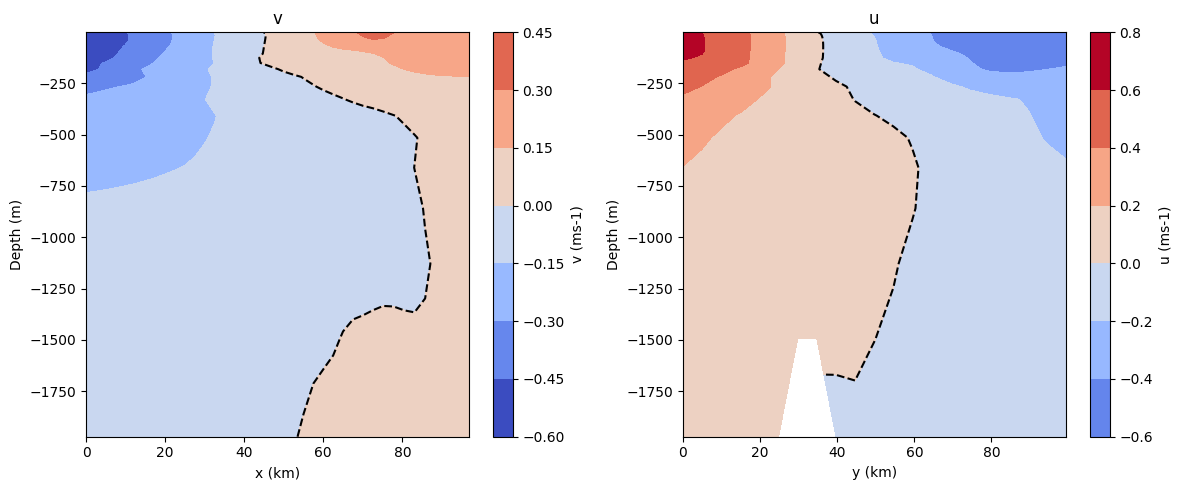

In [4]:
R = np.sqrt((lon_rho - edata.Lon)**2 + (lat_rho - edata.Lat)**2)
i_search, j_search = np.argwhere(R == np.min(R))[0]
SEARCH_WIDTH = 100000
DEPTH_LVL_LIMIT = 25

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

i_left, i_right, j_down, j_up = grid_finder(i_search, j_search, SEARCH_WIDTH)

# First subplot
v_cross = v[i_left:i_right, j_search, :DEPTH_LVL_LIMIT, t_mod]
v_data_range = np.nanmax(np.abs(v_cross))
x = distance(lat_rho[i_left, j_search], lon_rho[i_left, j_search], lat_rho[i_left:i_right, j_search], lon_rho[i_left:i_right, j_search])/1000
z = z_r[150, 150, :DEPTH_LVL_LIMIT]

X, Z = np.meshgrid(x, z)

c1 = axs[0].contourf(X, Z, v_cross.T, cmap=plt.get_cmap('coolwarm'), vmin=-v_data_range, vmax=v_data_range)
c1_contour = axs[0].contour(X, Z, v_cross.T, levels=[0], colors='black', linestyles='--')
axs[0].set_xlabel('x (km)')
axs[0].set_ylabel('Depth (m)')
axs[0].set_title('v')
fig.colorbar(c1, ax=axs[0], label='v (ms-1)')

# Second subplot
u_cross = u[i_search, j_down:j_up, :DEPTH_LVL_LIMIT, t_mod]
u_data_range = np.nanmax(np.abs(u_cross))
y = distance(lat_rho[i_search, j_down], lon_rho[i_search, j_down], lat_rho[i_search, j_down:j_up], lon_rho[i_search, j_down:j_up])/1000
z = z_r[150, 150, :DEPTH_LVL_LIMIT]

Y, Z = np.meshgrid(y, z)

c2 = axs[1].contourf(Y, Z, u_cross.T, cmap=plt.get_cmap('coolwarm'), vmin=-u_data_range, vmax=u_data_range)
c2_contour = axs[1].contour(Y, Z, u_cross.T, levels=[0], colors='black', linestyles='--')
axs[1].set_xlabel('y (km)')
axs[1].set_ylabel('Depth (m)')
axs[1].set_title('u')
fig.colorbar(c2, ax=axs[1], label='u (ms-1)')

plt.tight_layout()
plt.show()

## COW

In [5]:
SEARCH_RADIUS_MAX = 50000
surf_lon = edata.Lon
surf_lat = edata.Lat

CURSPEED_THRESH = 0.05
OW_THRESH = -2e-11
RATIO_THRESH = 2/3

theta0 = np.deg2rad(edata.Lon)
phi0 = np.deg2rad(edata.Lat)

depth_dics = {}

c_lon, c_lat = surf_lon, surf_lat

for depth_lvl in range(25):

    SEARCH_RADIUS = 5000

    flag = 1
    while flag:
    
        R = distance(c_lat, c_lon, lat_rho, lon_rho)
        mask = R < SEARCH_RADIUS
    
        cur_speed_masked = np.where(mask, cur_speed[:,:,depth_lvl, t_mod], np.nan) 
        ow_masked = np.where(mask, ow[:,:,depth_lvl, t_mod], np.nan) 
    
        pot_i, pot_j = np.where((cur_speed_masked < CURSPEED_THRESH) & (ow_masked < OW_THRESH))

        if len(pot_i) != 0:
            ratio = len(pot_i)/sum(sum(mask))
        else:
            ratio = 0
            
        if ratio <= RATIO_THRESH and ratio != 0:
            X = [lon_rho[pot_i, pot_j], lat_rho[pot_i, pot_j]]
            C = np.mean(X, axis=1)
            c_lon, c_lat = C

            lons = lon_rho[pot_i, pot_j]
            lats = lat_rho[pot_i, pot_j]
            
            lonr = np.deg2rad(lons)
            latr = np.deg2rad(lats)
            r_earth = 6371000
            x = r_earth * np.cos(phi0) * (lonr - theta0)
            y = r_earth * (latr - phi0)
            
            xc = r_earth * np.cos(phi0) * (np.deg2rad(c_lon) - theta0)
            yc = r_earth * (np.deg2rad(c_lat) - phi0)

            pot_ow = ow_masked[pot_i, pot_j]
            pot_cur_speed = cur_speed_masked[pot_i, pot_j]

            df = pd.DataFrame({
                'Pot i': pot_j,
                'Pot j': pot_j,
                'x': x,
                'y': y,
                'OW': pot_ow,
                'CurSpeed': pot_cur_speed
            })
            
            depth_dics['Depth'+str(depth_lvl)] = {'df': df, 'xc': xc, 'yc': yc, 'Search Radius': SEARCH_RADIUS, 'Depth': z_r[150,150,depth_lvl]}

            flag = 0
                        
        elif SEARCH_RADIUS <= SEARCH_RADIUS_MAX:
            
            SEARCH_RADIUS += 5000
    
        else:
            flag = 0


In [6]:
def eddy_centric_grid_distances(i_search, j_search, i_left, i_right, j_down, j_up):
    lonc = lon_rho[i_search, j_search]
    latc = lat_rho[i_search, j_search]
    def make_left_values_negative(arr):
        zero_index = np.where(arr == 0)[0]
        if zero_index.size == 0:
            return arr
        zero_index = zero_index[0]
        arr[:zero_index] = -np.abs(arr[:zero_index])
        return arr
    x = make_left_values_negative(distance(latc, lonc, lat_rho[i_left:i_right,j_search], lon_rho[i_left:i_right,j_search]))
    y = make_left_values_negative(distance(latc, lonc, lat_rho[i_search,j_down:j_up], lon_rho[i_search,j_down:j_up]))
    return x, y

def rotate_30_clockwise(x, y):
    theta = np.deg2rad(30)
    rotation_matrix = np.array([
        [np.cos(theta), -np.sin(theta)],
        [np.sin(theta), np.cos(theta)]
    ])
    points = np.vstack((x, y))
    rotated_points = rotation_matrix @ points
    x_rotated, y_rotated = rotated_points
    return x_rotated, y_rotated

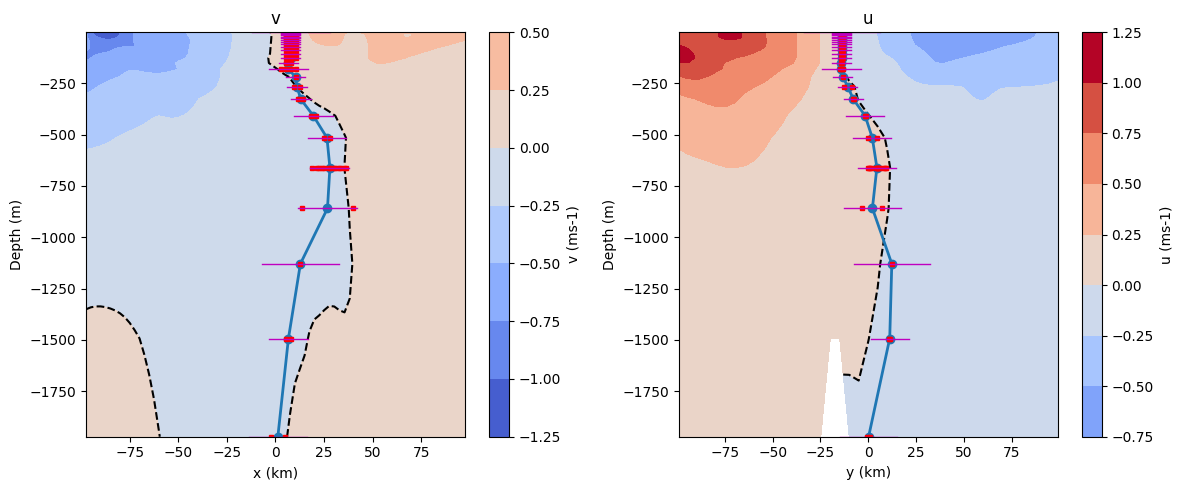

In [7]:
import numpy as np
import matplotlib.pyplot as plt

R = np.sqrt((lon_rho - edata.Lon)**2 + (lat_rho - edata.Lat)**2)
i_search, j_search = np.argwhere(R == np.min(R))[0]

DISPLAY_WIDTH = 200000
DEPTH_LVL_LIMIT = 25

i_left, i_right, j_down, j_up = grid_finder(i_search, j_search, DISPLAY_WIDTH)

x, y = eddy_centric_grid_distances(i_search, j_search, i_left, i_right, j_down, j_up)

x = x / 1000
y = y / 1000

xc_raw = []
yc_raw = []
zc = []
xp_raw = []
yp_raw = []
zp = []
radii = []

for depth_dic in depth_dics:
    xc_raw.append(depth_dics[depth_dic]['xc'])
    yc_raw.append(depth_dics[depth_dic]['yc'])
    zc.append(depth_dics[depth_dic]['Depth'])
    radii.append(depth_dics[depth_dic]['Search Radius'])

    xp_raw.extend(depth_dics[depth_dic]['df'].x)
    yp_raw.extend(depth_dics[depth_dic]['df'].y)
    zp.extend([float(depth_dics[depth_dic]['Depth'])]*len(depth_dics[depth_dic]['df'].x))

zp = np.array(zp)
xc, yc = rotate_30_clockwise(xc_raw, yc_raw)
xp, yp = rotate_30_clockwise(xp_raw, yp_raw)

xc = xc / 1000
yc = yc / 1000
radii = np.array(radii) / 1000
xp = xp / 1000
yp = yp / 1000

z = z_r[150, 150, :DEPTH_LVL_LIMIT]

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# First subplot
v_cross = v[i_left:i_right, j_search, :DEPTH_LVL_LIMIT, t_mod]
v_data_range = np.nanmax(np.abs(v_cross))

X, Z = np.meshgrid(x, z)

c1 = axs[0].contourf(X, Z, v_cross.T, cmap='coolwarm', vmin=-v_data_range, vmax=v_data_range)
c1_contour = axs[0].contour(X, Z, v_cross.T, levels=[0], colors='black', linestyles='--')
axs[0].set_xlabel('x (km)')
axs[0].set_ylabel('Depth (m)')
axs[0].set_title('v')
axs[0].plot(xc, zc, 'o-', linewidth=2)
axs[0].plot(xp, zp, 's', markersize=3, color='red')
axs[0].plot([xc-radii, xc+radii], [zc, zc], '-', linewidth=1, color='m')
fig.colorbar(c1, ax=axs[0], label='v (ms-1)')

# Second subplot
u_cross = u[i_search, j_down:j_up, :DEPTH_LVL_LIMIT, t_mod]
u_data_range = np.nanmax(np.abs(u_cross))

Y, Z = np.meshgrid(y, z)

c2 = axs[1].contourf(Y, Z, u_cross.T, cmap='coolwarm', vmin=-u_data_range, vmax=u_data_range)
c2_contour = axs[1].contour(Y, Z, u_cross.T, levels=[0], colors='black', linestyles='--')
axs[1].set_xlabel('y (km)')
axs[1].set_ylabel('Depth (m)')
axs[1].set_title('u')
axs[1].plot(yc, zc, 'o-', linewidth=2)
axs[1].plot(yp, zp, 's', markersize=3, color='red')
axs[1].plot([yc-radii, yc+radii], [zc, zc], '-', linewidth=1, color='m')
fig.colorbar(c2, ax=axs[1], label='u (ms-1)')

plt.tight_layout()
plt.show()
